In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 950)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from IPython.display import Image  
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import pydotplus
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb
import math


import shap
from alibi.explainers import KernelShap
from mlxtend.plotting import scatterplotmatrix



# Samþjöppun

## Viðskipti á markaði



Hér er reiknað hve mikill hluti viðskipta fer fram yfir markaðinn. 

Lífleg viðskipti voru með aflamark á fiskveiðiárunum 17/18,18/19 og 19/20.  Þetta er sýnt á myndinni hér að neðan en þar kemur fram hlutfall aflamarks sem fór yfir á milli aðila. 

Nokkuð stór hluti aflamarks er færður á milli skipa ár hvert og eru ekki merkjanlegar breytingar á þessu magni á milli ára.  Myndin sýnir til dæmis að um 25% aflamarks í þorski er fært á milli aðila.


Text(0, 0.5, 'Prósenta á markað')

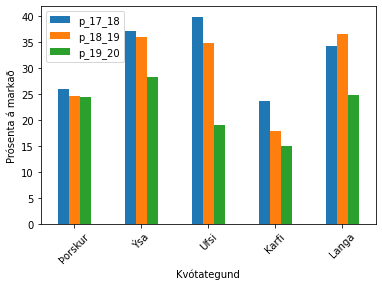

In [2]:
path1= "C://Users//Lenovo//ownCloud//Radgjof//Ráðgjöf//Brim//"
xl = pd.ExcelFile(path1+"Yfirlit_uthlutun_1920.xlsx")
df_uthlutun = xl.parse('Úthlutun snyrt') 
df_uthlutun


df_uthlutun['p_17_18']=df_uthlutun['m_17_18']/df_uthlutun['Óslægt_17_18']/10
df_uthlutun['p_18_19']=df_uthlutun['m_18_19']/df_uthlutun['Óslægt_18_19']/10
df_uthlutun['p_19_20']=df_uthlutun['m_19_20']/df_uthlutun['Óslægt_19-20']/10


df_uthlutun.head(5).plot(x="Kvótategund",y=['p_17_18','p_18_19','p_19_20'], kind='bar')

plt.xticks(rotation=45)
plt.ylabel('Prósenta á markað')



Nokkuð stór hluti aflamarks er færður á milli skipa ár hvert og eru ekki merkjanlegar breytingar á þessu magni á milli ára.  Myndin sýnir til dæmis að um 25% aflamarks í þorski er færðt á milli aðila. Meirihlutinn aflamarksins er oftast færður á milli ótengdra aðila eins og eftirfarandi mynd sýnir.

Text(0, 0.5, 'Prósenta á milli óskyldra aðila')

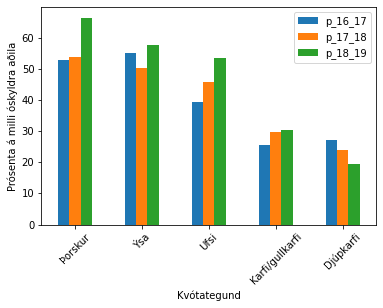

In [4]:
xl = pd.ExcelFile(path1+"toflur_og_talnagogn_2018_2019.xlsx")
df_flutningur = xl.parse('Flutningur_aflamarks_1819') 

df_flutningur['p_19_20']=df_flutningur['m_19_20']/df_flutningur['f_s_19_20']*100
df_flutningur['p_18_19']=df_flutningur['m_18_19']/df_flutningur['f_s_18_19']*100
df_flutningur['p_17_18']=df_flutningur['m_17_18']/df_flutningur['f_s_17_18']*100
df_flutningur['p_16_17']=df_flutningur['m_16_17']/df_flutningur['f_s_16_17']*100


df_flutningur.head(5).plot(x="Kvótategund",y=['p_16_17','p_17_18','p_18_19'], kind='bar')


plt.xticks(rotation=45)
plt.ylabel('Prósenta á milli óskyldra aðila')

## HHI útreikningar

In [5]:

pd.options.display.float_format = '{:,.1f}'.format


xl = pd.ExcelFile(path1+"Samthjoppun_1920_uppsjávarfiskur.xlsx")
df_fyrir = xl.parse('SÞ_fyrir') 
df_eftir = xl.parse('SÞ_eftir') 
df_eftir_kmb_grb = xl.parse('SÞ__eftir_kmb_grb') 

df_hámörk = xl.parse('Hámörk')



In [6]:
df_fyrir = df_fyrir.drop(["Röð"],axis=1)
df_fyrir = df_fyrir.drop("Samtals 434317446",axis=1)

df_eftir = df_eftir.drop(["Röð"],axis=1)
df_eftir = df_eftir.drop("Samtals 434317446",axis=1)

df_eftir_kmb_grb = df_eftir_kmb_grb.drop(["Röð"],axis=1)
df_eftir_kmb_grb = df_eftir_kmb_grb.drop("Samtals 434317446",axis=1)


df_fyrir.rename(columns = {'Hlutfall  %':'ÞÍG'}, inplace = True)
df_eftir.rename(columns = {'Hlutfall  %':'ÞÍG'}, inplace = True)
df_eftir_kmb_grb.rename(columns = {'Hlutfall  %':'ÞÍG'}, inplace = True)



In [7]:
fiskar=list(df_fyrir.columns)

fiskar.remove('Eigandi')
fiskar.remove('ÞÍG')


## Samþjöppun og samjöppunarhlutföll

Hér að neðan eru HHI stuðlar og CR stuðlar reiknaðir og settir í töflu. Í töflunni kemur fram að HHI  stuðull fyrir markaðinn með þorsksígildistonn var 479 á árinu 2019.  Ef yfirráð hafa breyst í Brimi á árinu 2019 hækkar hann í 605.  

Í báðum tilvikum er stuðullinn langt undir þeim mörkum sem einkenna samþjappaða markaði en þar er talað um 2500 eða meira.  Breytingin er einnig einungis 126 stig sem er nokkur en ekki umtalsverð í þessu samhengi. Hið sama má segja um CR8 stuðulinn, en þar er breytingin úr 52 í 57 sem eru 5 stig sem er ekki umtalsvert

Það er því ekki unnt að komast að þeirri niðurstöðu að um samþjappaðan markað sé að ræða eða að breytingar séu umtalsverðar hafi yfirráð á annað borð breyst. Lengst til hægri má svo sjá áhrifin af kaupunum á Kambi og Grábrók.  

Í MHHI útreikningum hér að neðan er farið ítarlegar yfir Kamb, Grábrók og Þórsberg.



In [8]:
HHI_fyrir = df_fyrir.ÞÍG.multiply(100).pow(2).sum()
HHI_eftir = df_eftir.ÞÍG.multiply(100).pow(2).sum()
HHI_eftir_kmb_grb = df_eftir_kmb_grb.ÞÍG.multiply(100).pow(2).sum()
HHI_mismunur = HHI_eftir - HHI_fyrir
HHI_mismunur_kmb_grb = HHI_eftir_kmb_grb - HHI_eftir

CR4_fyrir = df_fyrir.ÞÍG.multiply(100).head(3).sum()
CR4_eftir = df_eftir.ÞÍG.multiply(100).head(3).sum()

print("HHI fyrir þorskígildistonn fyrir 8.september 2019:", "%.1f" % HHI_fyrir)
print("HHI fyrir þorskígildistonn eftir 8.september 2019:", "%.1f" % HHI_eftir)
print("Hækkun á HHI fyrir þorskígildistonn fyrir og eftir 8.september 2019:",
      "%.1f" % HHI_mismunur)

print("HHI fyrir þorskígildistonn fyrir kaup á Kambi og Grábrók:",
      "%.1f" % HHI_eftir)
print("HHI fyrir þorskígildistonn eftir 8.september 2019:",
      "%.1f" % HHI_eftir_kmb_grb)
print("Hækkun á HHI fyrir þorskígildistonn fyrir og eftir 8.september 2019:",
      "%.1f" % HHI_mismunur_kmb_grb)

#Töflur búnar til fyrir skýrslu:
t_fyrir = df_fyrir
t_fyrir['ÞÍG'] = df_fyrir.ÞÍG.multiply(100)
t_fyrir['HHI'] = df_fyrir.ÞÍG.pow(2)
t_fyrir = t_fyrir.drop(t_fyrir.iloc[:, 2:32], axis=1)
t_fyrir.head(4)

t_eftir = df_eftir
t_eftir['ÞÍG'] = df_eftir.ÞÍG.multiply(100)
t_eftir['HHI'] = df_eftir.ÞÍG.pow(2)
t_eftir = t_eftir.drop(t_eftir.iloc[:, 2:32], axis=1)
t_eftir.head(8)

t_eftir_kmb_grb = df_eftir_kmb_grb
t_eftir_kmb_grb['ÞÍG'] = df_eftir_kmb_grb.ÞÍG.multiply(100)
t_eftir_kmb_grb['HHI'] = df_eftir_kmb_grb.ÞÍG.pow(2)
t_eftir_kmb_grb = t_eftir_kmb_grb.drop(t_eftir_kmb_grb.iloc[:, 2:32], axis=1)
t_eftir_kmb_grb.head(8)

t_saman = pd.concat([t_fyrir, t_eftir, t_eftir_kmb_grb], axis=1)

t_saman.columns = [
    'Eigandi fyrir', 'ÞÍG fyrir', 'HHI fyrir', 'Eigandi eftir', 'ÞÍG eftir',
    'HHI eftir', 'Eigandi', 'ÞÍG eftir_kmb_grb', 'HHI eftir_kmb_grb'
]

t_saman.head(8)

HHI fyrir þorskígildistonn fyrir 8.september 2019: 478.6
HHI fyrir þorskígildistonn eftir 8.september 2019: 604.5
Hækkun á HHI fyrir þorskígildistonn fyrir og eftir 8.september 2019: 125.9
HHI fyrir þorskígildistonn fyrir kaup á Kambi og Grábrók: 604.5
HHI fyrir þorskígildistonn eftir 8.september 2019: 627.4
Hækkun á HHI fyrir þorskígildistonn fyrir og eftir 8.september 2019: 23.0


,Eigandi fyrir,ÞÍG fyrir,HHI fyrir,Eigandi eftir,ÞÍG eftir,HHI eftir,Eigandi,ÞÍG eftir_kmb_grb,HHI eftir_kmb_grb
0,Brim + ÖV,11.8,138.2,Brim + ÖV+ÚR+KG,16.8,280.9,Brim + ÖV+ÚR+KG+KB+GB,17.4,304.1
1,Samherji+ Sæból+ÚA,9.1,82.3,Samherji+ Sæból+ÚA,9.1,82.3,Samherji+ Sæból+ÚA,9.1,82.3
2,FISK + SC,5.6,30.9,FISK + SC,5.6,30.9,FISK + SC,5.6,30.9
3,Síldarvinnslan + BH +RH,8.1,65.9,Síldarvinnslan + BH +RH,8.1,65.9,Síldarvinnslan + BH +RH,8.1,65.9
4,Vinnslustöðin hf.,5.0,25.3,Vinnslustöðin hf.,5.0,25.3,Vinnslustöðin hf.,5.0,25.3
5,Þorbjörn hf.,4.8,23.1,Þorbjörn hf.,4.8,23.1,Þorbjörn hf.,4.8,23.1
6,Skinney-Þinganes hf.,4.2,17.8,Skinney-Þinganes hf.,4.2,17.8,Skinney-Þinganes hf.,4.2,17.8
7,Útgerðarfélag Reykjavíkur hf.,4.0,15.7,Ísfélag Vestmannaeyja hf.,3.8,14.4,Ísfélag Vestmannaeyja hf.,3.8,14.4


In [ ]:
HHI_listi = []

for fiskur in fiskar:

    df_fyrir = df_fyrir.sort_values(by=[fiskur], ascending=False)
    df_eftir = df_eftir.sort_values(by=[fiskur], ascending=False)

    cr4_fyrir = df_fyrir[fiskur].head(3).sum()
    cr4_eftir = df_eftir[fiskur].head(3).sum()
    cr4_mismunur = cr4_eftir - cr4_fyrir

    cr8_fyrir = df_fyrir[fiskur].head(7).sum()
    cr8_eftir = df_eftir[fiskur].head(7).sum()
    cr8_mismunur = cr8_eftir - cr8_fyrir

    HHI_fyrir = df_fyrir[fiskur].pow(2).sum()
    HHI_eftir = df_eftir[fiskur].pow(2).sum()

    HHI_mismunur = HHI_eftir - HHI_fyrir
    HHI_mismunur
    HHI_listi.append([
        HHI_fyrir, HHI_eftir, HHI_mismunur, cr8_fyrir, cr8_eftir, cr8_mismunur
    ])

df4 = pd.DataFrame(HHI_listi,
                   columns=[
                       'HHI_fyrir', 'HHI_eftir', 'HHI breyting', 'cr8_fyrir',
                       'cr8_eftir', 'cr8 breyting'
                   ],
                   index=fiskar)

df4.drop(["Skrápflúra","Hlýri", "Sandkoli", "Skötuselur", "Blálanga","Litli karfi","Úthafskarfi",\
          "Langlúra","Þykkvalúra", "Keila", "Langa","Skarkoli","Steinbítur","Úthafsrækja", "Rækja við Snæf.nes",\
         "Arnarfj.rækja","Rækja í Djúpi", "Humar","Gulllax","Djúpkarfi","Grálúða","Gullkarfi","Ufsi","Ýsa","Þorskur"],axis=0, inplace=True)
pd.options.display.float_format = '{:,.0f}'.format
df4.sort_values(by=['HHI breyting'], ascending=False).head(23)

# Aðfallslíkön
Framkvæmdir voru samsvarandi útreikningar og í skýrslu Hagfræðistofnunar 2010 og fyrir sömu fisktegundir (þorsk, ýsu, ufsa, steinbít, skarkola, löngu og skötusel).  Auk þess var þetta reiknað fyrir karfa.  Notast við nokkrar gerðir aðfallsgreiningar.  Það var niðurstaða Hagfræðistofnunar að markaður með aflamark væri skilvirkur á þeim tíma. Útreikningar okkar benda til þess að svo sé einnig nú.  Hér að neðan er tekið dæmi um þorsk en fjallað er um hinar tegundirnar í viðauka III . 


In [ ]:
xl = pd.ExcelFile(
    "C://Users//Lenovo//ownCloud//radgjof///Ráðgjöf//Brim//fish_prices.xlsx")
df_fish_prices = xl.parse('Þorskur')

df_fish_prices.sort_values('viðskiptaverð_isk', inplace=True)

df_fish_prices.reset_index(inplace=True, drop=True)

X = df_fish_prices.loc[:, 'erlent_verð_isk':'olíuverð_isk']
Y = df_fish_prices['viðskiptaverð_isk']

## Einstakar fisktegundir

Einstakar fisktegundir fyrir fiskveiðiárið 19/20 voru skoðaðar og HHI stuðlarnir reiknaðir.  

## XGB regression

In [ ]:
seed = 2
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    shuffle=True)

# DMatrices

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Building a baseline model
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

params = {
    # Parameters that we are going to tune.
    'max_depth': 8,
    'min_child_weight': 3,
    'eta': 0.1,
    'subsample': .7,
    'colsample_bytree': .7,
    # Other parameters
    'objective': 'reg:squarederror',
    'eval_metric': "mae"
}

xgb_regressor = xgb.train(params,
                          dtrain,
                          num_boost_round=100,
                          evals=[(dtest, "Test")],
                          verbose_eval=10)

y_pred = xgb_regressor.predict(dtest)

In [ ]:
print("mae  : %.2f" % mean_absolute_error(y_test, y_pred))
print("r2   : %.2f" % r2_score(y_test, y_pred))
print("evs  : %.2f" % explained_variance_score(y_test, y_pred))

x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
xgb.plot_importance(xgb_regressor,
                    importance_type='total_gain',
                    show_values=False,
                    title='Mikilvægi þátta',
                    ylabel='þættir',
                    xlabel='einkunn')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type='bar')
shap.dependence_plot('erlent_verð_isk', shap_values, X)

shap.force_plot(explainer.expected_value, shap_values, X)

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

In [ ]:
cols = [
    'viðskiptaverð_isk',
    'mánuðir_eftir',
    'erlent_verð_isk',
    'olíuverð_isk',
]

scatterplotmatrix(df_fish_prices[cols].values,
                  figsize=(10, 8),
                  names=cols,
                  alpha=0.5)
plt.tight_layout()
#plt.savefig('images/10_03.png', dpi=300)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=35,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)

In [ ]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(
    y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' %
      (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

# Línuleg aðfallsgreining

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

# Train classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

reg1.fit(X, Y)
reg2.fit(X, Y)
reg3.fit(X, Y)

ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg.fit(X, Y)

In [ ]:
xt = X[:31]
yt = Y[:31]

pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

In [ ]:
plt.figure()

plt.plot(pred1, 'g*', label='GB spá')
plt.plot(yt, 'b', label='Rauntölur')
plt.plot(pred2, 'b^', label='SLembiskógar spá')
plt.plot(pred3, 'ys', label='Línuleg aðfallsgreining spá')
plt.plot(pred4, 'r*', ms=10, label='Meðaltöl spánna')

plt.tick_params(axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False)
plt.ylabel('Verð sem líkönin spá fyrir leigu á aflahlutdeild')
plt.xlabel('gögn úr þýði í stærðarröð')
plt.legend(loc="best")
plt.title('Spár ýmissa líkana og meðaltöl þeirra')

plt.show()

In [ ]:
met=sm.OLS(Y,X)
met=met.fit()
met.summary()



In [ ]:
X = pd.concat(
    [np.log(X.erlent_verð_isk), X.mánuðir_eftir,
     np.log(X.olíuverð_isk)],
    axis=1)
Y=np.log(Y)

In [ ]:
met=sm.OLS(Y,X)
met=met.fit()
met.summary()

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=.2,
                                                    random_state=2)

from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()
regr = RANSACRegressor(random_state=0).fit(X, Y)

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

# The coefficients

regr.score(X, Y)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))